In [1]:
%matplotlib notebook

import matplotlib as mpl
import DataSetQuery
import datetime
import pandas as pd
import MalardHelpers
import geopandas as gp
import matplotlib.pyplot as plt
import rasterio
from rasterio.plot import show
from rasterio.mask import mask
from shapely.geometry import Polygon, Point
import os
import numpy as np
from scipy.interpolate import griddata
import pandas as  pd
import json
import math
from pandas.io.json import json_normalize
import statsmodels.api as sm
from matplotlib.colors import LinearSegmentedColormap


In [16]:
environmentName = 'DEVv2'
# 400000 500000 0 100000 mtngla testdataset HMA RGIv60 SDCv10 DebugRun
parentDsName = 'mtngla'
dataset = 'Ready3'
runName='TestRun3'
region='himalayas'
size = 100000

query = DataSetQuery.DataSetQuery('http://localhost:9000',environmentName)

bbx = query.getDataSetBoundingBox( parentDsName, dataset, region)
bbx = json.loads(bbx)
minT = datetime.datetime.utcfromtimestamp(bbx['minTime'])
maxT = datetime.datetime.utcfromtimestamp(bbx['maxTime'])

#The overall data cube for the two datasets
print(query.getDataSetBoundingBox(parentDsName,dataset, region))

{"gridCellMinX":-1600000,"gridCellMaxX":1400000,"gridCellMinY":-1000000,"gridCellMaxY":800000,"minTime":1279266673,"maxTime":1556338066,"totalPoints":2809598,"numberOfShards":256}


In [17]:
stats = query.getRunStatistics(parentDsName, runName)
stats = json.loads(stats)
dfStats = json_normalize(stats)
dfStats.head()

,gridCell.minX,gridCell.minY,gridCell.size,statistics.DebrisMaskArea,statistics.GlacierMaskArea,statistics.afterGlacierMask,statistics.meanElevationDifference,statistics.pointsWithinDebrisMask,statistics.result_avgX,statistics.result_avgY,...,statistics.result_refDifference_2013,statistics.result_refDifference_2014,statistics.result_refDifference_2015,statistics.result_refDifference_2016,statistics.result_refDifference_2017,statistics.result_refDifference_2018,statistics.result_refDifference_2019,statistics.result_total,statistics.tdx2_filtered,statistics.tdx_filtered
0,-1600000,-100000,100000,0.863542,3.401935,106,-22.422802,67,-1.536373e+06,-21292.235597,...,0.000000,-29.751991,-9.820787,-11.176451,-21.182444,-5.338712,-7.113104,106,NaN,127816.0
1,-1500000,0,100000,0.216172,0.749176,6,-10.264159,0,-1.443186e+06,29895.766148,...,-7.946642,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6,NaN,82086.0
2,-1500000,400000,100000,10.772159,107.072272,2003,-15.974319,305,-1.440702e+06,459939.024227,...,-23.118501,-22.218580,-10.585680,-29.813283,-28.030374,-4.983522,-57.700119,2003,NaN,191837.0
3,-1400000,0,100000,23.879357,63.412965,2053,-10.438546,1346,-1.339945e+06,57970.013154,...,-13.118634,-7.109773,-10.878485,-12.928447,-5.411608,-15.874281,-12.089743,2053,NaN,85282.0
4,-1400000,100000,100000,2.365825,11.978117,151,-17.005372,92,-1.337447e+06,131513.591615,...,-15.771851,-23.351697,-17.716917,-24.619519,0.000000,-22.863138,8.903162,151,NaN,362414.0


In [18]:
# convert center points to geo points
crs = json.loads(query.getProjection(parentDsName, region))['proj4']

def toGeoData(data):
    # Convert gridcells to point geometries in the middle of the cell
    geometry = [Point(xy) for xy in zip(data['gridCell.minX']+(size/2), data['gridCell.minY']+(size/2))]
    gData = gp.GeoDataFrame(data, crs=crs, geometry=geometry)
    return gData

dfStats = toGeoData(dfStats.copy())

In [45]:
dfStats.head()

,gridCell.minX,gridCell.minY,gridCell.size,statistics.DebrisMaskArea,statistics.GlacierMaskArea,statistics.afterGlacierMask,statistics.meanElevationDifference,statistics.pointsWithinDebrisMask,statistics.result_avgX,statistics.result_avgY,...,statistics.result_refDifference_2014,statistics.result_refDifference_2015,statistics.result_refDifference_2016,statistics.result_refDifference_2017,statistics.result_refDifference_2018,statistics.result_refDifference_2019,statistics.result_total,statistics.tdx2_filtered,statistics.tdx_filtered,geometry
0,-1600000,-100000,100000,0.863542,3.401935,106,-22.422802,67,-1.536373e+06,-21292.235597,...,-29.751991,-9.820787,-11.176451,-21.182444,-5.338712,-7.113104,106,NaN,127816.0,POINT (-1550000 -50000)
1,-1500000,0,100000,0.216172,0.749176,6,-10.264159,0,-1.443186e+06,29895.766148,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6,NaN,82086.0,POINT (-1450000 50000)
2,-1500000,400000,100000,10.772159,107.072272,2003,-15.974319,305,-1.440702e+06,459939.024227,...,-22.218580,-10.585680,-29.813283,-28.030374,-4.983522,-57.700119,2003,NaN,191837.0,POINT (-1450000 450000)
3,-1400000,0,100000,23.879357,63.412965,2053,-10.438546,1346,-1.339945e+06,57970.013154,...,-7.109773,-10.878485,-12.928447,-5.411608,-15.874281,-12.089743,2053,NaN,85282.0,POINT (-1350000 50000)
4,-1400000,100000,100000,2.365825,11.978117,151,-17.005372,92,-1.337447e+06,131513.591615,...,-23.351697,-17.716917,-24.619519,0.000000,-22.863138,8.903162,151,NaN,362414.0,POINT (-1350000 150000)


In [19]:
def addColumns(dfCell):
    #year, month, day = [], [], []
    #dateobject = []
    # xdiff and ydiff are relative x and y positions to the centre
    xdiff, ydiff = [], []
    # glacial year
    #gla_year = []
    for i, row in dfCell.iterrows():
        #date = datetime.datetime.utcfromtimestamp(dfCell.time[i])
        #year.append(date.year)
        #month.append(date.month)
        #day.append(date.day)
        #dateobject.append(date)
        #yearmonth.append('%s-%s' % (date.year, date.month))
        # x and y distance to center point of gridcell
        xdiff.append((dfCell.x[i] % size) - (size/2))
        ydiff.append((dfCell.y[i] % size) - (size/2))
        #if date.month < 10:
        #    gla_year.append(date.year)
        #else:
        #    gla_year.append(date.year+1)

    #dfCell['gla_year'] = gla_year
    #dfCell['year'], dfCell['month'], dfCell['day'] = year, month, day
    #dfCell['dateobject'] = dateobject
    #dfCell['yearmonth'] = yearmonth
    dfCell['offsetX'], dfCell['offsetY'] = xdiff, ydiff
    return dfCell

In [22]:
dfStats.head()

,gridCell.minX,gridCell.minY,gridCell.size,statistics.DebrisMaskArea,statistics.GlacierMaskArea,statistics.afterGlacierMask,statistics.meanElevationDifference,statistics.pointsWithinDebrisMask,statistics.result_avgX,statistics.result_avgY,...,regression.a.se,regression.b,regression.b.se,regression.c,regression.c.se,regression.c.year,regression.c.se.year,regression.const,regression.const.se,regression.count
0,-1600000,-100000,100000,0.863542,3.401935,106,-22.422802,67,-1.536373e+06,-21292.235597,...,0.000638,-0.009746,0.002042,7.961810e-08,1.285443e-08,2.510836,0.405377,190.580162,63.669254,106.0
1,-1500000,0,100000,0.216172,0.749176,6,-10.264159,0,-1.443186e+06,29895.766148,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-1500000,400000,100000,10.772159,107.072272,2003,-15.974319,305,-1.440702e+06,459939.024227,...,0.000046,-0.000209,0.000123,-1.117577e-08,7.446449e-09,-0.352439,0.234831,4.047428,10.607570,2003.0
3,-1400000,0,100000,23.879357,63.412965,2053,-10.438546,1346,-1.339945e+06,57970.013154,...,0.000021,0.000100,0.000029,6.279155e-09,5.980244e-09,0.198019,0.188593,-18.498772,8.515566,2053.0
4,-1400000,100000,100000,2.365825,11.978117,151,-17.005372,92,-1.337447e+06,131513.591615,...,0.000672,-0.002868,0.000684,-3.380867e-08,2.143677e-08,-1.066190,0.676030,9.540742,32.531749,151.0


In [20]:
# Add columns for filling in
newColumns = ['regression.rsquared', 'regression.a', 'regression.a.se', 'regression.b', 'regression.b.se', \
              'regression.c', 'regression.c.se', 'regression.c.year', 'regression.c.se.year', 'regression.const', 'regression.const.se', 'regression.count']
dfStats = dfStats.reindex(columns=np.append( dfStats.columns.values, newColumns))

In [21]:
for idx, line in dfStats.iterrows():
    if dfStats['statistics.afterGlacierMask'][idx] > 50:
        min_X,max_X=line['gridCell.minX'],line['gridCell.minX']+line['gridCell.size']
        min_Y,max_Y=line['gridCell.minY'],line['gridCell.minY']+line['gridCell.size']
        file = query.getNetCdfFile(parentDsName,dataset,region,min_X,max_X,min_Y,max_Y,minT,maxT)
        dfCell = MalardHelpers.getDataFrameFromNetCDF(file)
        # add glacier year and relation to center point
        addColumns(dfCell)
        # chuck away data before glacier year 2011
        #dfCell = dfCell[(dfCell.gla_year > 2010) & (dfCell.gla_year < 2019)]
        if (line['statistics.result_total'] != dfCell.shape[0]):
            print(line)
            print(line['statistics.result_total'], dfCell.shape[0])
        # model variables
        vals = np.asarray([dfCell.time, dfCell.offsetX, dfCell.offsetY])
        vals = np.transpose(vals)
        vals = sm.add_constant(vals)
        elev = dfCell.refDifference

        # Create model and fit it (least squares)
        model = sm.OLS(elev, vals)
        # OR robust model -- not that it won't have r squared
        #model = sm.RLM(y, x)
        results = model.fit()
        #dfStats['regression.rsquared'][idx] = results.rsquared
        #dfStats['regression.a'][idx] = results.params.x2
        #dfStats['regression.a.se'][idx] = results.bse.x2
        #dfStats['regression.b'][idx] = results.params.x3
        #dfStats['regression.b.se'][idx] = results.bse.x3
        #dfStats['regression.c'][idx] = results.params.x1
        #dfStats['regression.c.se'][idx] = results.bse.x1
        #dfStats['regression.c.year'][idx] = dfStats['regression.c'][idx]*31536000
        #dfStats['regression.c.se.year'][idx] = dfStats['regression.c.se'][idx]*31536000
        #dfStats['regression.const'][idx] = results.params.const
        #dfStats['regression.const.se'][idx] = results.bse.const
        #dfStats['regression.count'][idx] = results.nobs
        
        dfStats.at[idx, 'regression.rsquared'] = results.rsquared
        dfStats.at[idx, 'regression.a'] = results.params.x2
        dfStats.at[idx,'regression.a.se'] = results.bse.x2
        dfStats.at[idx,'regression.b'] = results.params.x3
        dfStats.at[idx,'regression.b.se'] = results.bse.x3
        dfStats.at[idx,'regression.c'] = results.params.x1
        dfStats.at[idx,'regression.c.se'] = results.bse.x1
        dfStats.at[idx,'regression.c.year'] = dfStats['regression.c'][idx]*31536000
        dfStats.at[idx,'regression.c.se.year'] = dfStats['regression.c.se'][idx]*31536000
        dfStats.at[idx,'regression.const'] = results.params.const
        dfStats.at[idx,'regression.const.se'] = results.bse.const
        dfStats.at[idx,'regression.count'] = results.nobs
        del dfCell
        query.releaseCache(file)

gridCell.minX                                         200000
gridCell.minY                                              0
gridCell.size                                         100000
statistics.DebrisMaskArea                             2.9695
statistics.GlacierMaskArea                           512.642
statistics.afterGlacierMask                            72921
statistics.meanElevationDifference                  0.747399
statistics.pointsWithinDebrisMask                         53
statistics.result_avgX                                212848
statistics.result_avgY                               49820.1
statistics.result_count_2010                            2909
statistics.result_count_2011                            8507
statistics.result_count_2012                            8083
statistics.result_count_2013                           13822
statistics.result_count_2014                            6571
statistics.result_count_2015                            7710
statistics.result_count_

<IPython.core.display.Javascript object>


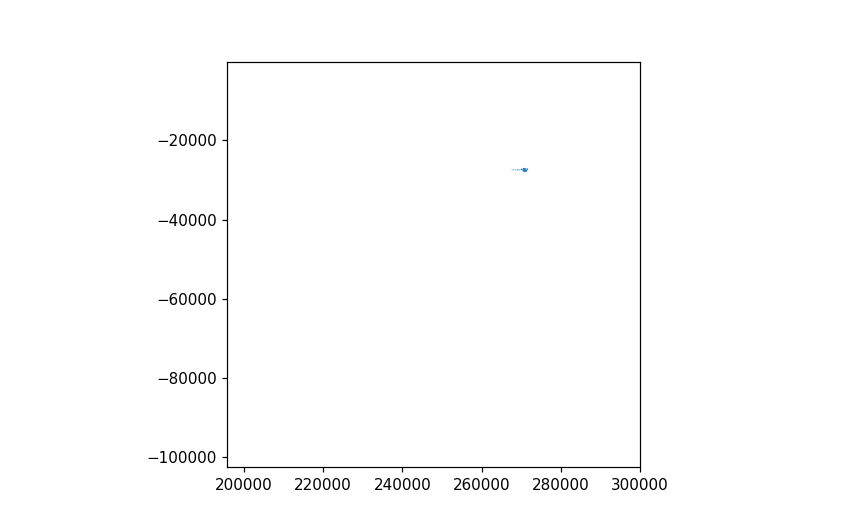

In [4]:
# read glaciers
pathM = "/data/puma1/scratch/mtngla/masks/himalayas/glacier-outlines/13_14_15_rgi60_Himalayas_mask.shp"
glaciers = gp.read_file(pathM)
glaciers.plot()

In [49]:
# convert center points to geo points
crs = json.loads(query.getProjection(parentDsName, region))['proj4']

def toGeoData(data):
    data.drop(['geometry'], axis=1)
    geometry = []
    for idx, line in data.iterrows():
        minX,maxX=line['gridCell.minX'],line['gridCell.minX']+line['gridCell.size']
        minY,maxY=line['gridCell.minY'],line['gridCell.minY']+line['gridCell.size']
        geometry.append(Polygon([(minX,minY), (minX,maxY), (maxX,maxY), (maxX,minY), (minX,minY)]))
    gData = gp.GeoDataFrame(data, crs=crs, geometry=geometry)
    return gData

statsPolys = toGeoData(dfStats.copy())

In [13]:
rivers = gp.read_file("/data/puma1/scratch/mtngla/background-shapefiles/rivers_reprojected.shp")
countries = gp.read_file("/data/puma1/scratch/mtngla/background-shapefiles/countries.shp")

<IPython.core.display.Javascript object>


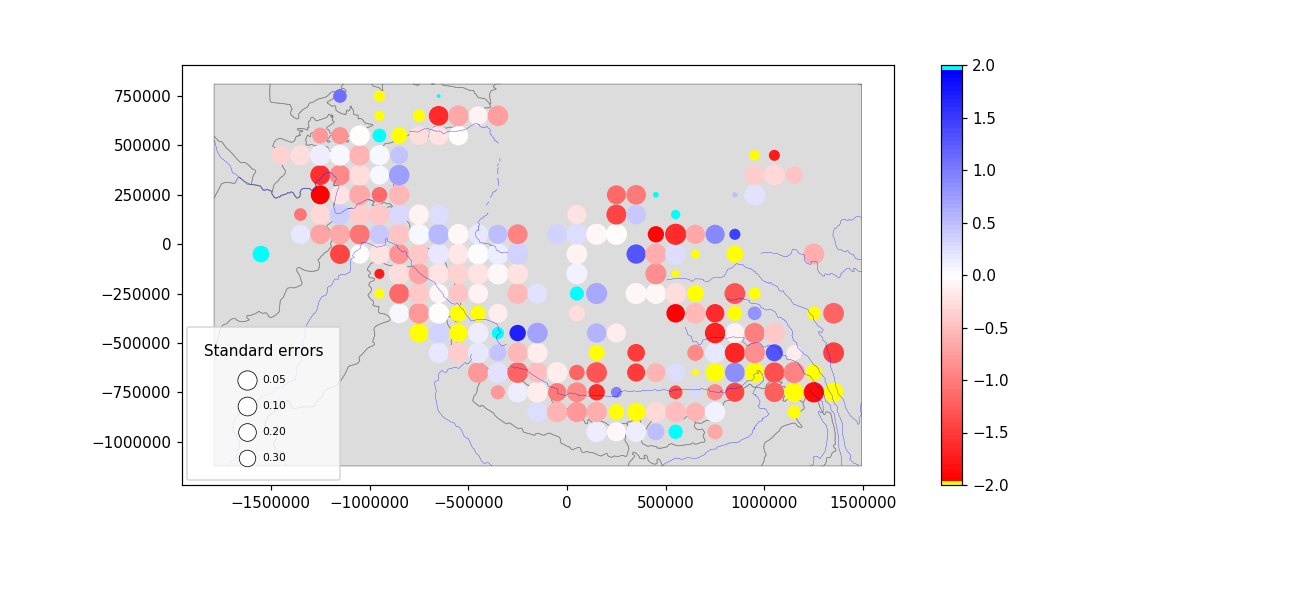

/home/earthwave/miniconda3/envs/dev/lib/python3.7/site-packages/matplotlib/collections.py:857: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


In [14]:
%matplotlib notebook


colors = [(1, 0, 0), (1, 1, 1), (0, 0, 1)]  # R -> W -> B
n_bin = 98  # Discretizes the interpolation into bins
# Create the colormap
cm_ = LinearSegmentedColormap.from_list('my_list', colors, N=n_bin)
cm = LinearSegmentedColormap.from_list('extremes',[(1, 1, 0)]+list(map(cm_,range(98)))+[(0, 1, 1)], N=100)

#dfStatsfiltered = dfStats[(dfStats['regression.c.se.year'] <= 0.20)]
dfStatsfiltered = dfStats[(dfStats['regression.count'] > 50)]
vmin=-2
vmax=2
fig, ax = plt.subplots(figsize=(11,5))

# plot rivers and country boundaries
countries.plot(ax=ax, edgecolor='grey', color='gainsboro', linewidth=0.5)
rivers.plot(ax=ax, edgecolor='blue', linewidth=0.2)


#markersize = dfStats['regression.count']/100
msf = 170
markersize = (1-dfStatsfiltered['regression.c.se.year'])*msf
dfStatsfiltered.plot(ax=ax, column='regression.c.year', markersize=markersize, legend=True, vmin=vmin, \
                     vmax=vmax, cmap=cm)

labels = ["0.05", "0.10", "0.20", "0.30"]
sizes = [(1-0.05)*msf, (1-0.10)*msf, (1-0.20)*msf, (1-0.30)*msf]
markers=[]
for size in sizes:
    markers.append(plt.scatter([],[], s=size, label=size, color='white', edgecolor='black', linewidth=0.5))

plt.legend(handles=markers)
leg = plt.legend(markers, labels, ncol=1, frameon=True, fontsize=7,handlelength=1, loc = 3, borderpad = 1.6,\
handletextpad=1, title='Standard errors', scatterpoints = 1, labelspacing=1.5)

#for i, txt in enumerate(dfStatsfiltered['regression.count']):
    #print(dfStatsfiltered.loc[dfStatsfiltered.index[i], 'statistics.afterGlacierMask'])
    #if dfStatsfiltered.loc[dfStatsfiltered.index[i], 'statistics.afterGlacierMask'] > 50:
    #    ax.annotate(int(txt), (dfStatsfiltered.loc[dfStatsfiltered.index[i], 'gridCell.minX']+ \
    #                           (size/2)+10000, dfStatsfiltered.loc[dfStatsfiltered.index[i], 'gridCell.minY']+\
    #                           (size/2)+10000), fontsize=5)
#for i, txt in enumerate(dfStatsfiltered['regression.c.year']):
#    print(dfStatsfiltered.loc[dfStatsfiltered.index[i], 'statistics.afterGlacierMask'])
#    if dfStatsfiltered.loc[dfStatsfiltered.index[i], 'statistics.afterGlacierMask'] > 50:
#        ax.annotate('{0:.2g}'.format(txt), (dfStatsfiltered.loc[dfStatsfiltered.index[i], 'gridCell.minX']+ \
#                               (size/2)+10000, dfStatsfiltered.loc[dfStatsfiltered.index[i], 'gridCell.minY']+\
#                               (size/2)+10000), fontsize=5)

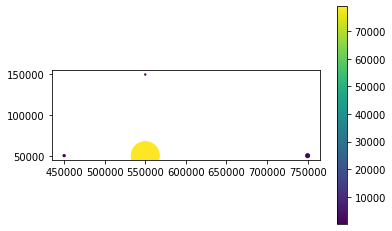

In [56]:
%matplotlib inline
markersize = dfStats['regression.count']/100
dfStats.plot(column='regression.count', markersize=markersize, legend=True)

In [15]:
dfStats.to_file("regression_results/ols_run_tdx2.gpkg", driver="GPKG")